In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.cross_validation import cross_val_score, StratifiedKFold

In [3]:
from copy import deepcopy

In [4]:
sys.path.append("./tools")
sys.path.append("./final_project")

In [5]:
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from util import create_email_features, create_binary_missing_features

In [6]:
target_label = 'poi'

email_features = ['to_messages',
                  'from_messages',
                  'from_this_person_to_poi',
                  'from_poi_to_this_person',
                  'shared_receipt_with_poi']

finance_features = ['salary',
                    'deferral_payments',
                    'total_payments',
                    'exercised_stock_options',
                    'bonus',
                    'restricted_stock',
                    'restricted_stock_deferred',
                    'total_stock_value',
                    'expenses',
                    'loan_advances',
                    'other',
                    'director_fees',
                    'deferred_income',
                    'long_term_incentive']

features_list = email_features + finance_features

In [7]:
with open("final_project/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#### Outlier Removal

In [8]:
outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']

for outlier in outliers:
    data_dict.pop(outlier, 0)

#### Feature Engineering

In [9]:
my_data = deepcopy(data_dict)

In [10]:
binary_features = create_binary_missing_features(my_data, features_list)

In [11]:
binary_features = list(binary_features)

In [12]:
features_list += binary_features

In [13]:
create_email_features(my_data, features_list)

In [14]:
features_list = [target_label] + features_list

#### Data Preparation

In [15]:
data = featureFormat(my_data, features_list)

In [16]:
y, X = targetFeatureSplit(data)

In [17]:
X, y = np.array(X), np.array(y)

In [18]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### First Model - Decision Tree Classifier

In this section, I would like to start with a very simple Decision Tree based model since we do not require any kind of preprocessing the data in terms of scaling or selecting the features.

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
print classification_report(y_test, dt_clf.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.92      0.88      0.90        25
        1.0       0.40      0.50      0.44         4

avg / total       0.85      0.83      0.84        29



As can be seen from the above classification report, it can be seen that the decision tree classifier is not able to classify the positive class as well as the negative class. However, since the dataset is small, there is a fair chance that this classifier would be overfitting and would have a lot of variance for different train and tet samples. In order to estimate the generalization capability, let us try parameter tuning and cross validation to gauge the performance of the model. Since, we want to optimize both the precision and recall score for our problem (data is imbalanced and hence, accuracy is not a good measure), we can use F1 score to evaluate our model as it combines precision and recall in harmonic mean.

Also, we will optimize over below parameters:

* criteria - Criteria for identifying the best feature for split.
* max_depth - This is the maximum depth of the tree.
* max_features - This is the number of features to be used for building the tree.
* min_samples_leaf - This is the number of samples at a leaf node.
* class_weight - Required as the data is imbalanced. We will use 'balanced' as our parameter.

In [20]:
dt_clf = DecisionTreeClassifier(random_state=42)

criteria = ['gini', 'entropy']
max_depth = [1, 3, 5, 7]
max_features = [5, 6, 10, 20, len(features_list)-1]
min_samples_leaf = [1, 3, 5]
class_weight = ['balanced']

param_grid = {'criterion': criteria,
              'max_depth': max_depth,
              'max_features': max_features,
              'min_samples_leaf': min_samples_leaf,
              'class_weight': class_weight}

estimator_dt = GridSearchCV(dt_clf, param_grid, cv=5, scoring='f1_macro')

estimator_dt.fit(X_train, y_train)

dt_predictions = estimator_dt.predict(X_test)

print classification_report(y_test, dt_predictions)

C:\Users\Prasun Srivastava\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0       0.92      0.88      0.90        25
        1.0       0.40      0.50      0.44         4

avg / total       0.85      0.83      0.84        29



As can be seen from the above classification report, it seems as if the best decision tree estimator obtained has a higher precision but lower recall. Let us try to see how the different parameters affect the training and cross validation score individually.

In [21]:
from sklearn.learning_curve import learning_curve, validation_curve

def plot_validation_curve(parameter_values, train_scores, validation_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")

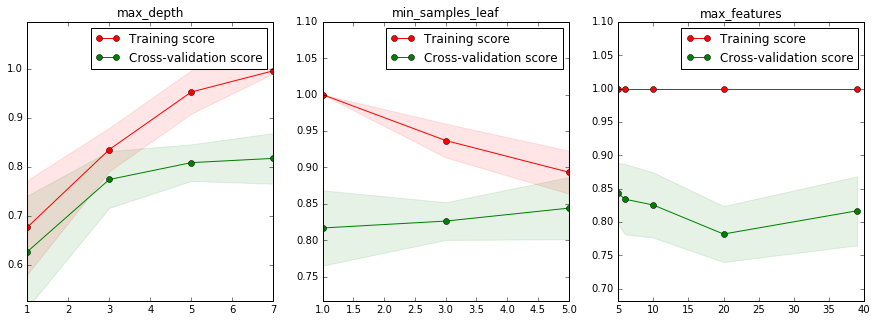

In [22]:
figure = plt.figure(figsize=(15, 5))
for i, param in enumerate(['max_depth', 'min_samples_leaf', 'max_features']):
    training_scores, validation_scores = validation_curve(DecisionTreeClassifier(random_state=42,
                                                                                 class_weight='balanced'),
                                                          X_train, y_train,
                                                          param_name = param,
                                                          param_range = param_grid[param],
                                                          cv=5)
    
    figure.add_subplot(1, 3, i+1)
    plt.title(param)
    plot_validation_curve(param_grid[param], training_scores, validation_scores)

As can be seen from the above plots, none of the parameters are able to generalize and there is a huge amount of variance in the validation scores as seen from the standard deviation of the score. In order to reduce this variance, let us try to build a Random Forest model.

#### Random Forest Classifer

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10,
                            random_state=42)

rf.fit(X_train, y_train)

print classification_report(y_test, rf.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94        25
        1.0       1.00      0.25      0.40         4

avg / total       0.91      0.90      0.87        29



Here, again, the random forest model has also precision and recall 0. However, let us try to tune the model and cross-validate the results.

In [24]:
rf_model= RandomForestClassifier(class_weight='balanced', random_state=999)

num_estimators = [5, 10, 20, 50]
leaf_size = [1, 3, 5]
max_features = [5, 6, 10, 20]
param_grid = {'n_estimators': num_estimators,
              'max_features': max_features,
              'min_samples_leaf':leaf_size}

rf_estimator = GridSearchCV(rf_model, param_grid, scoring="f1_macro", cv=10)

rf_estimator.fit(X_train, y_train)

print classification_report(y_test, rf_estimator.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.87      0.80      0.83        25
        1.0       0.17      0.25      0.20         4

avg / total       0.77      0.72      0.75        29



As we can see, the random forest model is working just okay. Let us check the best parameters for the model.

In [25]:
rf_estimator.best_params_

{'max_features': 6, 'min_samples_leaf': 5, 'n_estimators': 20}

Let us plot the learning curve for the model and see if the model has converged or it could have performed well with more data.

In [26]:
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")

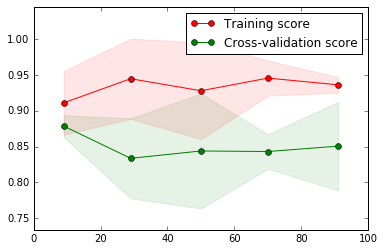

In [27]:
training_sizes, training_score, validation_score = learning_curve(RandomForestClassifier(class_weight='balanced',
                                                                max_features=rf_estimator.best_params_['max_features'],
                                                                min_samples_leaf=rf_estimator.best_params_['min_samples_leaf'],
                                                                n_estimators=rf_estimator.best_params_['n_estimators']), 
                                                              X_train, y_train, cv=5)

plot_learning_curve(training_sizes, training_score, validation_score)

As we can see that there is a huge gap between the training and cross-validation score, we could do much better with more data. However, we do not have an option for the same. Let us check the top 10 predictors for our random forest model

In [28]:
# identify the indices for the sorted feature importance
idx = np.argsort(rf_estimator.best_estimator_.feature_importances_)
idx = idx[::-1] # sort in descending order by reversing the ascending order sorted list
idx = idx[:10] # pick only top 10
features = features_list[1:]
for feature, importance in zip(np.array(features)[idx], rf_estimator.best_estimator_.feature_importances_[idx]):
    print feature, ':', importance

bonus : 0.157060369518
expenses : 0.133966247938
total_payments : 0.0825256529672
shared_receipt_with_poi : 0.0718387038758
other : 0.0696056718957
to_messages : 0.0522401221852
deferred_income : 0.049280099791
long_term_incentive : 0.0488999013762
from_messages : 0.0438084864194
total_stock_value : 0.0407910164488


Next, let us try a logistic regression model. Since, logistic regression models belong to linear models and are fairly fast to train, we are going to attemp the cross-validated hyperparameter tuning directly. Also, we will try to select features based on two feature selection methods:

- SelectKBest
- Based on Random Forest Feature importance

In [29]:
# Logistic Regression with SelectKBest as the feature Selector

pipe_selectk_lr = make_pipeline(StandardScaler(),
                                SelectKBest(),
                                LogisticRegression(random_state=42, class_weight='balanced'))

C = [10**num for num in range(-6, 6)]
param_grid_selectk = {'selectkbest__k': [5, 6, 10, 12, 15, 20, "all"],
                      'logisticregression__C':C, 
                      'logisticregression__penalty':['l2', 'l1']}

estimator_selectk_lr = GridSearchCV(pipe_selectk_lr, param_grid_selectk, cv=10, scoring='f1_macro')

estimator_selectk_lr.fit(X_train, y_train)

print classification_report(y_test, estimator_selectk_lr.predict(X_test))
print
print estimator_selectk_lr.best_params_

C:\Users\Prasun Srivastava\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [14 27] are constant.
  UserWarning)
C:\Users\Prasun Srivastava\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


             precision    recall  f1-score   support

        0.0       0.84      0.64      0.73        25
        1.0       0.10      0.25      0.14         4

avg / total       0.74      0.59      0.65        29


{'selectkbest__k': 'all', 'logisticregression__penalty': 'l1', 'logisticregression__C': 1}


In [30]:
# logistic regression with random forest as a feature selector

pipe_rf_lr = make_pipeline(StandardScaler(),
                           SelectFromModel(RandomForestClassifier(class_weight='balanced', random_state=2016)),
                           LogisticRegression(random_state=42, class_weight='balanced'))

C = [10**num for num in range(-6, 6)]
num_estimators = [5, 10, 20, 50]
leaf_size = [1, 3, 5]
max_features = [5, 6, 10, 20]

param_grid_rf = {'selectfrommodel__threshold': ["mean", "median", "1.25*mean"],
                 'selectfrommodel__estimator__n_estimators':num_estimators,
                 'selectfrommodel__estimator__max_features':max_features,
                 'selectfrommodel__estimator__min_samples_leaf':leaf_size,
                 'logisticregression__C':C, 
                 'logisticregression__penalty':['l2', 'l1']}

estimator_rf_lr = GridSearchCV(pipe_rf_lr, param_grid_rf, cv=3, scoring='f1_macro', n_jobs=3)

estimator_rf_lr.fit(X_train, y_train)

print classification_report(y_test, estimator_rf_lr.predict(X_test))
print
print estimator_rf_lr.best_params_

             precision    recall  f1-score   support

        0.0       0.90      0.72      0.80        25
        1.0       0.22      0.50      0.31         4

avg / total       0.81      0.69      0.73        29


{'selectfrommodel__threshold': 'median', 'logisticregression__penalty': 'l1', 'logisticregression__C': 10, 'selectfrommodel__estimator__n_estimators': 10, 'selectfrommodel__estimator__max_features': 10, 'selectfrommodel__estimator__min_samples_leaf': 1}


As we can see, the random forest based feature selection along with the logistic regression is working better than the `SelectKBest`, we are going to use this model further. Next, we find out the features selected according to the random forest feature importances.

In [31]:
# Identify the features selected
selector = estimator_rf_lr.best_estimator_.named_steps['selectfrommodel']
np.array(features_list[1:])[selector.estimator_.feature_importances_ >= selector.threshold_]

array(['to_messages', 'from_messages', 'from_this_person_to_poi',
       'from_poi_to_this_person', 'shared_receipt_with_poi', 'salary',
       'deferral_payments', 'total_payments', 'exercised_stock_options',
       'bonus', 'restricted_stock', 'total_stock_value', 'expenses',
       'other', 'deferred_income', 'long_term_incentive', 'missing_bonus',
       'missing_exercised_stock_options', 'missing_to_messages',
       'interaction_with_poi'], 
      dtype='|S33')

Next, we are going to prepare the data with these features now and then try to cross validate the results again with the Logistic Regression Parameters tuned by grid search earlier.

In [32]:
selected_features = ['poi',
                     'to_messages',
                     'from_messages',
                     'from_this_person_to_poi',
                     'from_poi_to_this_person',
                     'shared_receipt_with_poi',
                     'salary',
                     'deferral_payments', 
                     'total_payments', 
                     'exercised_stock_options',
                     'bonus', 
                     'restricted_stock', 
                     'total_stock_value', 
                     'expenses',
                     'other', 
                     'deferred_income', 
                     'long_term_incentive', 
                     'missing_bonus',
                     'missing_exercised_stock_options', 
                     'missing_to_messages',
                     'interaction_with_poi']

data_selected = featureFormat(my_data, selected_features, sort_keys=True)

labels, features = targetFeatureSplit(data_selected)
labels, features = np.array(labels), np.array(features)


features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels,
                                                                            test_size=0.2,
                                                                            stratify=labels, 
                                                                            random_state=42)

lr = make_pipeline(StandardScaler(),
                   LogisticRegression(penalty='l1', C=10, class_weight='balanced', random_state=42))

folds = StratifiedKFold(labels_train, n_folds=10, shuffle=True, random_state=42)

precision = []
recall = []

for train_idx, test_idx in folds:
    
    train_X = features_train[train_idx]
    train_y = labels_train[train_idx]
    test_X = features_train[test_idx]
    test_y = labels_train[test_idx]

    lr.fit(train_X, train_y)
    pred = lr.predict(test_X)
    
    precision.append(precision_score(test_y, pred))
    recall.append(recall_score(test_y, pred))

print "Cross-Validated Average Precision:", round(np.mean(precision), 2)
print "Cross-Validated Average Recall:", round(np.mean(recall), 2), "\n"

# fit the model on whole data
lr.fit(features_train, labels_train)

# evaluate
print classification_report(labels_test, lr.predict(features_test))

Cross-Validated Average Precision: 0.46
Cross-Validated Average Recall: 0.55 

             precision    recall  f1-score   support

        0.0       0.89      0.96      0.92        25
        1.0       0.50      0.25      0.33         4

avg / total       0.84      0.86      0.84        29



In [33]:
test_classifier(lr, my_data, selected_features, folds=1000)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
	Accuracy: 0.81033	Precision: 0.37091	Recall: 0.60700	F1: 0.46046	F2: 0.53845
	Total predictions: 15000	True positives: 1214	False positives: 2059	False negatives:  786	True negatives: 10941

